In [189]:
# Install scikit-learn if not already installed
#Import libraries
import pandas as pd #For data manipulation and analysis
import os #For file and directory manipulation
import numpy as np #For numerical operations
import matplotlib.pyplot as plt #For data visualization
import seaborn as sns #For statistical data visualization
import random #For random number generation
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder #For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

Data Preprocessing

In [190]:
# Load data
filepath = 'loan_data.csv'  # Replace with your actual path
df_Train = pd.read_csv(filepath, sep=',')
# Display info about the Data
df_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [191]:
#Check what the Data looks like [first 10 rows]
display(df_Train.head(10))

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
6,26.0,female,Bachelor,93471.0,1,RENT,35000.0,EDUCATION,12.42,0.37,3.0,701,No,1
7,24.0,female,High School,95550.0,5,RENT,35000.0,MEDICAL,11.11,0.37,4.0,585,No,1
8,24.0,female,Associate,100684.0,3,RENT,35000.0,PERSONAL,8.90,0.35,2.0,544,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1


In [192]:
# Check for Duplicates and Drop them
before = df_Train.shape[0]
df_Train = df_Train.drop_duplicates()
after = df_Train.shape[0]
print(f"Duplicates dropped: {before - after}")
print(f"New shape: {df_Train.shape}")


Duplicates dropped: 0
New shape: (45000, 14)


In [193]:

# Encode categorical variables
label_cols = df_Train.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
for col in label_cols:
    df_Train[col] = le.fit_transform(df_Train[col].astype(str))


In [194]:
# View the updated Datatype info
df_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  int32  
 2   person_education                45000 non-null  int32  
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  int32  
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  int32  
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [195]:
#Renaming columns for better readability
df_Train.rename(columns={
    'person_age': 'Age',
    'person_gender': 'Gender',
    'person_education': 'Education_Level',
    'person_income': 'Annual_Income',
    'person_emp_exp': 'Employment_Years',
    'person_home_ownership': 'Home_Ownership',
    'loan_amnt': 'Loan_Amount',
    'loan_intent': 'Loan_Purpose',
    'loan_int_rate': 'Loan_Interest_Rate',
    'loan_percent_income': 'Loan_Percentage_Income',
    'cb_person_cred_hist_length': 'Credit_History_Length',
    'credit_score': 'Credit_Score',
    'previous_loan_defaults_on_file': 'Previous_Loan_Defaults',
    'loan_status': 'Loan_Status'
}, inplace=True)

#Save the cleaned data to a new CSV file
df_Train.to_csv('Cleaned_Data.csv', index=False)

# Check for remaining missing values
print(df_Train.isnull().sum())
print(f"Dataset shape : {df_Train.shape}")

Age                       0
Gender                    0
Education_Level           0
Annual_Income             0
Employment_Years          0
Home_Ownership            0
Loan_Amount               0
Loan_Purpose              0
Loan_Interest_Rate        0
Loan_Percentage_Income    0
Credit_History_Length     0
Credit_Score              0
Previous_Loan_Defaults    0
Loan_Status               0
dtype: int64
Dataset shape : (45000, 14)


Modelling | XGboost

In [196]:
# Define features, excluding ones that won't be used to train the Model and the target
X = df_Train.drop(columns=['Loan_Status', 'Age', 'Gender', 'Education_Level', 'Loan_Interest_Rate', 'Loan_Percentage_Income', 'Employment_Years'], axis=1)
y = df_Train['Loan_Status']

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

# Second split: 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [197]:
# Initialize and train XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.8,
    subsample=0.5,
    colsample_bytree=0.9,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Store evaluation results
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Evaluate model (output remains the same)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.8860740740740741

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      5250
           1       0.76      0.72      0.74      1500

    accuracy                           0.89      6750
   macro avg       0.84      0.83      0.83      6750
weighted avg       0.88      0.89      0.88      6750


Confusion Matrix:
[[4906  344]
 [ 425 1075]]


4-Vector Hyperparameter

In [198]:

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

def decode_vector(vector):
    max_depth = int(3 + vector[0] * 7)
    learning_rate = 0.01 + vector[1] * 0.29
    subsample = 0.38 + vector[2] * 0.5
    colsample_bytree = 0.5 + vector[3] * 0.5
    return max_depth, learning_rate, subsample, colsample_bytree

def evaluate_fitness(vector):
    max_depth, learning_rate, subsample, colsample_bytree = decode_vector(vector)
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=30,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        tree_method='hist',
        random_state=42,
        verbosity=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

def four_vector_optimization(pop_size=5, iterations=5, alpha=0.1):
    population = np.random.rand(pop_size, 4)
    fitness = np.array([evaluate_fitness(ind) for ind in population])
    best_idx = np.argmax(fitness)
    best_vector = population[best_idx].copy()
    
    for _ in range(iterations):
        for i in range(pop_size):
            new_vector = population[i] + alpha * (best_vector - population[i]) + alpha * np.random.rand(4)
            new_vector = np.clip(new_vector, 0, 1)
            new_fitness = evaluate_fitness(new_vector)
            if new_fitness > fitness[i]:
                population[i] = new_vector
                fitness[i] = new_fitness
                if new_fitness > fitness[best_idx]:
                    best_idx = i
                    best_vector = new_vector.copy()
                    
    return decode_vector(best_vector), fitness[best_idx]

# Optimize and train model
best_params, best_acc = four_vector_optimization()
print("Best Hyperparameters:")
print(f" Max_depth: {best_params[0]}")
print(f" Learning_rate: {best_params[1]:.4f}")
print(f" Subsample: {best_params[2]:.4f}")
print(f" Colsample_bytree: {best_params[3]:.4f}")
print(f"Validation Accuracy: {best_acc:.4f}")

Best Hyperparameters:
 Max_depth: 9
 Learning_rate: 0.1624
 Subsample: 0.5925
 Colsample_bytree: 0.7206
Validation Accuracy: 0.9047


In [199]:
best_params, best_acc = four_vector_optimization()
max_depth, learning_rate, subsample, colsample_bytree = best_params

# Initialize and train the XGBoost model with optimized hyperparameters
xgb_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=max_depth,
    learning_rate=learning_rate,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate model
accuracy_after = accuracy_score(y_test, y_pred)
class_report_after = classification_report(y_test, y_pred)
conf_matrix_after = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy_after)
print("\nClassification Report:")
print(class_report_after)
print("\nConfusion Matrix:")
print(conf_matrix_after)

C:\Users\Bruce Mphekgwane\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [05:06:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.902074074074074

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5250
           1       0.80      0.74      0.77      1500

    accuracy                           0.90      6750
   macro avg       0.87      0.84      0.85      6750
weighted avg       0.90      0.90      0.90      6750


Confusion Matrix:
[[4979  271]
 [ 390 1110]]


Explainability 

In [200]:
import shap

# Create a SHAP explainer for your trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [201]:

from IPython.display import display, HTML

# Show full text in DataFrame columns
pd.set_option('display.max_colwidth', None)

num_applicants = 10  # Show top 50 applicants
num_features = 5    # Top 5 contributing features

explanations = []

# Helper function for value readability
def readable_value(fname, val):
    if isinstance(val, (bool, np.bool_)):
        return "Yes" if val else "No"
    if fname.endswith("_Yes") or fname.endswith("_No"):
        return "Yes" if val == 1 else "No"
    if "_" in fname and (val == 1 or val == 0):
        base, cat = fname.rsplit("_", 1)
        if val == 1:
            return f"is {cat}"
        else:
            return f"is not {cat}"
    return val

# Loop through top applicants in X_test
for i in range(min(num_applicants, X_test.shape[0])):
    shap_row = shap_values[i]
    feature_values = X_test.iloc[i]
    prediction = xgb_model.predict(X_test.iloc[[i]])[0]
    outcome = 'Approved' if prediction == 1 else 'Rejected'

    top_idx = np.argsort(np.abs(shap_row))[::-1][:num_features]
    reasons = []
    tips = set()

    for idx in top_idx:
        fname = X_test.columns[idx]
        val = feature_values[fname]
        val_str = readable_value(fname, val)
        impact = shap_row[idx]

        # Approved: show only positive contributions
        if outcome == 'Approved' and impact > 0:
            reasons.append(f"<b>{fname}</b> contributed positively to loan approval.")
        
        # Rejected: show only negative contributions and give advice
        elif outcome == 'Rejected' and impact < 0:
            reasons.append(f"<b>{fname}</b> contributed negatively to loan approval.")
            
            # Tailored advice based on actual negative influencer
            if 'Income' in fname:
                tips.add("Consider increasing your annual income or adding a co-applicant to strengthen your application.")
            elif 'Credit_Score' in fname:
                tips.add("Work on improving your credit score by paying bills on time and reducing outstanding debts.")
            elif 'Loan_Amount' in fname:
                tips.add("Try applying for a lower loan amount or extending your repayment period.")
            elif 'Home_Ownership' in fname:
                tips.add("Having stable home ownership can improve eligibility. Provide additional documentation if possible.")
            elif 'Credit_History_Length' in fname:
                tips.add("A longer credit history is favorable. Keep your credit accounts open and active.")
            elif 'Previous_Loan_Defaults' in fname:
                tips.add("Avoid Loan defaults and maintain a clean repayment record to boost your chances.")
            elif 'Loan_Purpose' in fname:
                tips.add("Loan purpose is HighRisk.")
            # elif 'Age' in fname:
            #     tips.add("Applicants closer to working age or retirement may face stricter criteria. Ensure your application reflects your financial stability.")
            else:
                tips.add(f"Review your {fname.replace('_', ' ')} for potential improvement.")

    loan_id = feature_values['Loan_ID'] if 'Loan_ID' in feature_values else f"Loan_{i+1}"
    advice_text = " ".join(tips) if outcome == 'Rejected' and tips else "No specific advice. Keep up the good financial habits."

    explanations.append({
        'Loan_Id': loan_id,
        'Outcome': outcome,
        'Reasons': " ".join(reasons) if reasons else "No major contributing factors found.",
        'Advice': advice_text
    })

explanation_df = pd.DataFrame(explanations)

# Display nicely
display(HTML(explanation_df.to_html(escape=False)))

,Loan_Id,Outcome,Reasons,Advice
0,Loan_1,Rejected,Previous_Loan_Defaults contributed negatively to loan approval. Loan_Amount contributed negatively to loan approval. Annual_Income contributed negatively to loan approval. Loan_Purpose contributed negatively to loan approval.,Loan purpose is HighRisk. Try applying for a lower loan amount or extending your repayment period. Consider increasing your annual income or adding a co-applicant to strengthen your application. Avoid Loan defaults and maintain a clean repayment record to boost your chances.
1,Loan_2,Approved,Annual_Income contributed positively to loan approval. Loan_Amount contributed positively to loan approval. Previous_Loan_Defaults contributed positively to loan approval. Credit_Score contributed positively to loan approval. Home_Ownership contributed positively to loan approval.,No specific advice. Keep up the good financial habits.
2,Loan_3,Rejected,Loan_Amount contributed negatively to loan approval. Annual_Income contributed negatively to loan approval. Home_Ownership contributed negatively to loan approval.,Try applying for a lower loan amount or extending your repayment period. Having stable home ownership can improve eligibility. Provide additional documentation if possible. Consider increasing your annual income or adding a co-applicant to strengthen your application.
3,Loan_4,Rejected,Previous_Loan_Defaults contributed negatively to loan approval. Loan_Amount contributed negatively to loan approval. Annual_Income contributed negatively to loan approval.,Try applying for a lower loan amount or extending your repayment period. Consider increasing your annual income or adding a co-applicant to strengthen your application. Avoid Loan defaults and maintain a clean repayment record to boost your chances.
4,Loan_5,Rejected,Previous_Loan_Defaults contributed negatively to loan approval. Annual_Income contributed negatively to loan approval. Home_Ownership contributed negatively to loan approval. Credit_Score contributed negatively to loan approval.,Consider increasing your annual income or adding a co-applicant to strengthen your application. Work on improving your credit score by paying bills on time and reducing outstanding debts. Having stable home ownership can improve eligibility. Provide additional documentation if possible. Avoid Loan defaults and maintain a clean repayment record to boost your chances.
5,Loan_6,Approved,Annual_Income contributed positively to loan approval. Previous_Loan_Defaults contributed positively to loan approval. Home_Ownership contributed positively to loan approval. Loan_Amount contributed positively to loan approval.,No specific advice. Keep up the good financial habits.
6,Loan_7,Rejected,Previous_Loan_Defaults contributed negatively to loan approval. Loan_Amount contributed negatively to loan approval. Annual_Income contributed negatively to loan approval.,Try applying for a lower loan amount or extending your repayment period. Consider increasing your annual income or adding a co-applicant to strengthen your application. Avoid Loan defaults and maintain a clean repayment record to boost your chances.
7,Loan_8,Rejected,Credit_Score contributed negatively to loan approval. Annual_Income contributed negatively to loan approval. Loan_Amount contributed negatively to loan approval.,Try applying for a lower loan amount or extending your repayment period. Consider increasing your annual income or adding a co-applicant to strengthen your application. Work on improving your credit score by paying bills on time and reducing outstanding debts.
8,Loan_9,Rejected,Previous_Loan_Defaults contributed negatively to loan approval. Annual_Income contributed negatively to loan approval. Loan_Purpose contributed negatively to loan approval. Home_Ownership contributed negatively to loan approval.,Loan purpose is HighRisk. Consider increasing your annual income or adding a co-applicant to strengthen your application. Having stable home ownership can im

C:\Users\Bruce Mphekgwane\AppData\Local\Temp\ipykernel_2360\269231715.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)


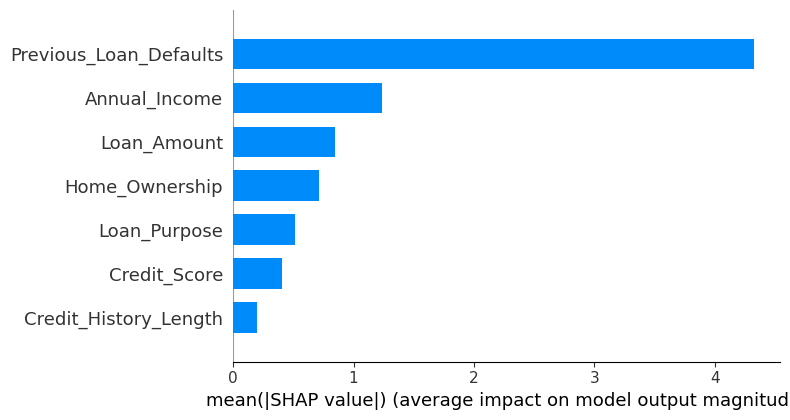

In [202]:

shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

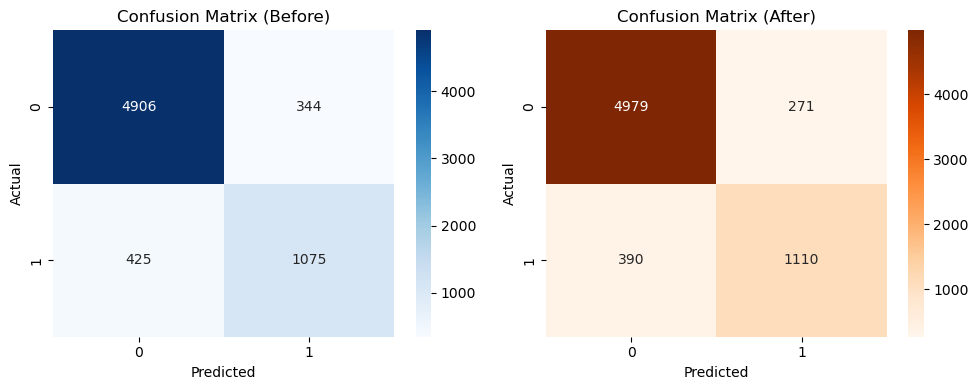

In [203]:
import re

# # 1. Bar graph for Accuracy and F1-score (class 1)
# fig, ax = plt.subplots(figsize=(7, 5))
# metrics = ['Accuracy', 'F1-score (class 1)']
# before_vals = [accuracy, f1_before]
# after_vals = [accuracy_after, f1_after]

# bar_width = 0.35
# x = np.arange(len(metrics))
# ax.bar(x - bar_width/2, before_vals, width=bar_width, label='Before 4-Vector', color='skyblue')
# ax.bar(x + bar_width/2, after_vals, width=bar_width, label='After 4-Vector', color='orange')
# for i, (b, a) in enumerate(zip(before_vals, after_vals)):
#     ax.text(i - bar_width/2, b + 0.01, f"{b:.3f}", ha='center', fontweight='bold')
#     ax.text(i + bar_width/2, a + 0.01, f"{a:.3f}", ha='center', fontweight='bold')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics)
# ax.set_ylim(0, 1)
# ax.set_ylabel('Score')
# ax.set_title('XGBoost Performance Comparison')
# ax.legend()
# plt.tight_layout()
# plt.show()

# 2. Confusion Matrices (Before and After)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Before)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(conf_matrix_after, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Confusion Matrix (After)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()